In [ ]:
%%javascript
    require.config({
        paths: { 
            d3: 'https://d3js.org/d3.v5.min'
        }
    });

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

from dag import draw_dag

<IPython.core.display.Javascript object>

In [5]:
draw_dag({
    'Treatment' : ['r'],
    'Corrections': ['Treatment'],
    'score' : ['Treatment'],
    'ActualFactors': ['score', 'r']
})

<IPython.core.display.Javascript object>

# Chapter 3: Dealing with interventions

The reference material is [here](http://bayes.cs.ucla.edu/PRIMER/primer-ch3.pdf)

In the [chapter 2 material](./chapter2.ipynb), we started covering the adjustment formula. The simplest example is the idea of a confounder:

In [6]:
draw_dag({'Temp': ['icecream', 'sharks']}, 
         positions={'Temp': [300, 100], 'icecream': [100,250], 'sharks':[500,250]})

<IPython.core.display.Javascript object>

There is no causal effect between icecream and sharks, but the confounding effect of temperature on each makes it seem like there is.

This model makes the _testable_ implication that 
$$P(\text{sharks}|\text{Temp, icecream}) = P(\text{sharks}|\text{Temp})$$
i.e. that knowing about ice-cream, _if you know about temperature_ , doesn't help.

### Showing dependence of ice-cream and sharks (and conditional independence)

In [7]:
N = 50000
T = np.random.uniform(low=60, high=100, size=N)
ice_cream_sales = np.random.normal(loc=T**2, scale=20, size=N)
shark_attacks = np.random.poisson(lam=np.sqrt(T)/5, size=N)

In [8]:
## There is a correlation between ice_cream sales and shark attacks:
# Note that we used a non-linear relationship between ice_cream and shark attacks
np.corrcoef(ice_cream_sales, shark_attacks)

array([[1.        , 0.09818199],
       [0.09818199, 1.        ]])

In [9]:
# Easier to see the effect if we group on the discrete variable
df = pd.DataFrame({'ice_cream': ice_cream_sales, 'shark_attacks': shark_attacks, 'T': T})
# Easier to see
df.groupby('shark_attacks').ice_cream.mean()

shark_attacks
0     6298.476296
1     6422.078144
2     6566.126489
3     6685.921823
4     6856.409677
5     6943.933533
6     7072.118485
7     7399.781862
8     7347.835181
9     6768.787956
10    8598.970243
Name: ice_cream, dtype: float64

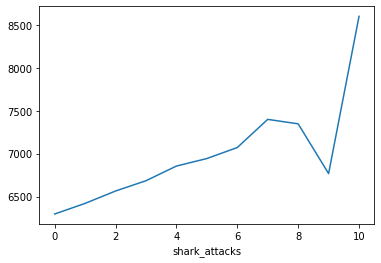

In [10]:
df.groupby('shark_attacks').ice_cream.mean().plot()

Within teach temperature bin (5 degree window) the correlation coefficient is much smaller.

In [11]:
df['T_bin'] = pd.cut(df['T'], bins=np.arange(60, 100, 5))
df.groupby('T_bin').apply(lambda gp: gp[['ice_cream', 'shark_attacks']].corr())

ice_cream  shark_attacks
T_bin                                           
(60, 65] ice_cream       1.000000       0.011481
         shark_attacks   0.011481       1.000000
(65, 70] ice_cream       1.000000       0.026043
         shark_attacks   0.026043       1.000000
(70, 75] ice_cream       1.000000       0.014786
         shark_attacks   0.014786       1.000000
(75, 80] ice_cream       1.000000       0.009290
         shark_attacks   0.009290       1.000000
(80, 85] ice_cream       1.000000       0.004494
         shark_attacks   0.004494       1.000000
(85, 90] ice_cream       1.000000       0.009031
         shark_attacks   0.009031       1.000000
(90, 95] ice_cream       1.000000       0.004968
         shark_attacks   0.004968       1.000000

Let's actually introduce a statistical independence test

In [12]:
## do test

## Intervention

In our shark attack example above, we see that opening or closing ice-cream stores would have no effect on shark attacks -- the ice-cream information has no way of flowing back through to the shark attacks.

In the previous lecture, we labeled probabilities as $P$ from the observational distribution, and $P_m$ from the modified distribution after we posed an intervention. The trick was to determine when an observational probability could be used for the modified distribution.

In the example of the ice-cream and the sharks, we have 
$$P_m(S | T) = P(S | T)$$
as however we step in and set the ice-cream level, the ice-cream has no real affect on shark attacks, so the observational probability and the probability we would have seen _if we intervened_ would be the same. However, it also tells us that
$$P_m(S | \text{T, ice-cream}) \neq P(S | \text{T, ice-cream})$$
because before modification the two were confounded by temperature, but after modification they were not.

In this particular example, the modification is trivial: our DAG asserts that ice-cream policy has nothing to do with shark attacks, and that $P(S|T)$ is the same if we intervene or not, so if we force everyone to eat ice-cream then $P(S|T)$ would be a description under the modified world of shark attacks.

In the next section, we will look at more formal rules for how to block

In [15]:
draw_dag({'X': ['Y'],
          'Z': ['A', 'Y'],
          'G': ['X', 'Z', 'Y'],
          'H': ['A', 'X']
})


<IPython.core.display.Javascript object>

### Blocking

Let's look at the slightly more involved example. This is based off Pearl's figure 3.7, with variable names changed to avoid using $Z$.

In [13]:
positions = {'Con1': [100, 50], 'Con2': [300, 100], 'Con3': [500, 50],
             'X': [200, 300], 'Y': [400,300]}

draw_dag({'X': ['Y'], 'Con1': ['X', 'Con2'], 'Con2': ['X', 'Y'], 'Con3': ['Con2', 'Y']},
          positions=positions)

<IPython.core.display.Javascript object>

If we want to isolated the effect of $X$ on $Y$:

1. What should we control on?
2. How do we extract the probabilities if we force everyone to have $X = 1$ (i.e. the "modified" probabilities) from the observational probabilities.

We can phase the answer in terms of the modified probability distribution, or the "do" operator.

### Modified probability distribution

If we forced $X=1$ for all participants, we have $P_m(X=1|....) = 1$, which is (presumably) different from the observational probabilities. We also know that the _effects_ on $X$ from anything else have changed.

Let's look at all the ways that $X$ can get information to $Y$ by listing all the paths:

| Path | Is causal |
| ---- | --------- |
| X -- Con1 -- Con2 -- Con3 -- Y | No |
| X -- Con1 -- Con2 -- Y | No |
| X -- Con2 -- Con3 -- Y | No |
| X -- Con2 -- Y | No |
| X -- Y | Yes |

Let's eliminate the last path (this is the effect we want to measure). From the remaining paths, we need to identify whether we have blocked this path in the modified graph. If we block all these dangerous paths from $X$ to $Y$, then in the modified graph, $X$ and $Y$ are $d$-separated, and we know they won't be (conditionally) dependent. 

i.e. Any conditional dependence we do find will be due to the paths we removed

In [ ]:
#modified DAG
draw_dag({'X': [], 'Con1': ['X', 'Con2'], 'Con2': ['X', 'Y'], 'Con3': ['Con2', 'Y']},
          positions=positions)

#### Analysis 1: Block nothing

| Path number | Path | Is blocked | Comments
| --- | --- | --- | --- |
| 1. | X <- Con1 -> Con2 <- Con3 -> Y | Yes | Con2 is a (non-controlled) collider |
| 2. | X <- Con1 -> Con2 -> Y | No | This path only contains forks (Con1) and chains. |
| 3. | X <- Con2 <- Con3 -> Y | No | Only has chains and a fork (Con3) |
| 4. | X <- Con2 -> Y | No | Con2 is a fork |


Note that on some paths `Con2` is a collider, on others it is part of a chain, and others it is part of a fork. Technically, nodes are not colliders/chains/forks, but components of _paths_ are.

We also see that path 4 requires that we block `Con2`.

#### Analysis 2: Only block Con2

| Path number | Path | Is blocked | Comments
| --- | --- | --- | --- |
| 1. | X <- Con1 -> Con2 <- Con3 -> Y | No | Con2 is a controlled collider |
| 2. | X <- Con1 -> Con2 -> Y | Yes | Controlling Con2 blocks info at Con2 |
| 3. | X <- Con2 <- Con3 -> Y | Yes | Controlling Con2 blocks into at Con2 |
| 4. | X <- Con2 -> Y | Yes | Controlling Con2 blocks info at Con2 |

The only ways of blocking path 1 (given that Con2 must be controlled) is to also control at least one of Con1 and Con3.

#### Which probabilities are the same?

If we control for Con2 and Con3, then $X$ and $Y$ are $d$-separated along all the non-causal paths. Then we have

$$P_m(Y|\text{X, Con2, Con3}) = P(Y|\text{X, Con2, Con3})$$

However, if $X$ is downstream, we generally don't have equality. For example
$$P_m(Y|\text{Con1}) \neq P(Y| \text{Con1})$$
because in the original DAG there is Con1 -> X -> Y, and intervening and changing $X$ manually is going to make this path look different than the one we observed.

**The (simplied) backdoor criterion**

Suppose we are intervening on a single node $X$, and the probabilities we would get post-intervention are $P_m$. $Y$ is any other node, and $Z$ is a set of nodes. We have
$$P_m(Y | \text{X, Z}) = P(Y|\text{X, Z})$$
whenever $X$ and $Y$ are $d$-separated controlling for $Z$ in that graph that has all paths from $X$ deleted.

In [ ]:
N = 500
con1 = np.random.normal(size=N)
con3 = np.random.normal(size=N)
con2 = 2*con1 - con3
X = 3*con1 + 2*con2 + 0.3*np.random.normal(size=N)
Y = 3*X + 1.5*con2 - 0.8*con3 + 0.5*np.random.normal(size=N)

df = pd.DataFrame({'X': X, 'con1': con1, 'con2': con2, 'con3': con3, 'Y': Y})
df.head()

In [ ]:
# Show that controlling for nothing does not work:
# We want to find the coefficient of $X$ being 3
lr = LinearRegression().fit(df[['X']], df.Y)
lr.coef_

In [ ]:
# Show that controlling for con2 and con3 allows correct identification
# of the coefficient
lr = LinearRegression().fit(df[['X', 'con2', 'con3']], df.Y)
lr.coef_

In [ ]:
## Now let's look at intervention
## We will change X --> 1
## and we will change Y --> Y_old - 3*X_old + 3
## i.e. keeping the same random draws etc that we had

df_modified = df.copy()
df_modified['Y'] = df_modified.Y - 3*df_modified.X + 3
df_modified['X'] = 1

In [ ]:
## **IF** P_m(Y|Con2, Con3) = P(Y|Con2, Con3) means that
## Y ~ Con2 + Con3 
## should have the same coefs in both dataframes

lr_orig = LinearRegression().fit(df[['con2', 'con3']], df.Y)
lr_modified = LinearRegression().fit(df_modified[['con2', 'con3']], df_modified.Y)

print(lr_orig.coef_, lr_modified.coef_)

Note that this does not work! We don't expect it to, based off the backdoor criteria. When whenever control for something, we implicitly 


## DAG class